# 프로젝트 : 인물 모드 문제점 찾기 

## Step 1. 인물모드 직접 해 보기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(3024, 3024, 3)


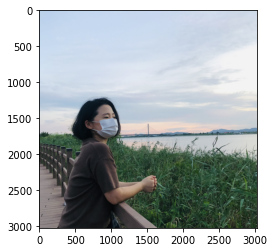

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels_1.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

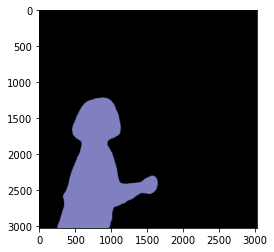

In [5]:
plt.imshow(output)
plt.show()

In [6]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [7]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


정확하게 사람임을 인식했다. 
옆모습인데도 정확히 인식이 된다. 


In [8]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [20]:
colormap[15]

array([192, 128, 128])

사람을 나타내는 값은 Array(192,128,128)RGB이다. 
우리가 추출해야하는 색상값은 BGR 순서로 바꿔줘야한다. 
-> (128, 128, 192)

In [23]:
seg_color = (128, 128, 192)

### seg_color로만 이루어진 마스크를 만들자.

(3024, 3024)


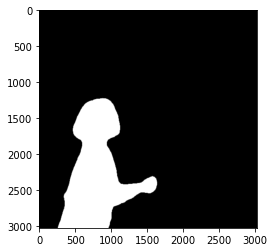

In [24]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

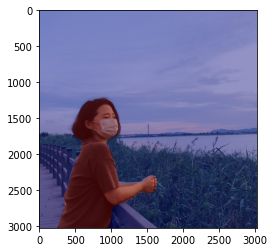

In [25]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

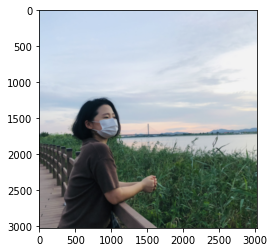

In [26]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요


img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

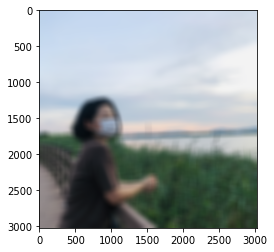

In [28]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요


img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

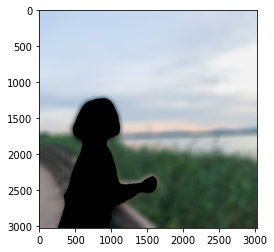

In [29]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

약간의 차이는 있지만, 명확하게 사람의 형체만 검은색으로 처리되었다. 

### "img_bg" 결과

bitwise_out함수를 이용하면 이미지가 반전된다. 

* 원래 마스크에서는 배경이 0, 사람이 255였다. 
* bitwise_not 연산 결과, 배경이 255, 사람이 0이 된다. 
* 그 결과 배경만 있는 영상을 얻을 수 있다. 

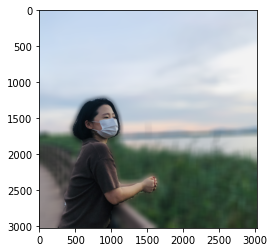

In [30]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()



Segmentation mask가 255인 부분만 원본 이미지를 갖고 온다. 아닌 영역은 블러된 이미지 값을 사용한다. 
(255인 부분 = img_bg결과 흑백으로 나온 부분.

## Step 2. 사진에서 문제점 찾기

### ResourceExhaustedError

원래는 귀여운 강아지의 사진을 이용했다. 
그런데

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,256,728] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]


위와 같은 오류가 발생했다. 



### 사진의 경계가 부자연스러움

## Step 3. 해결 방법을 제안해 보기

# 더욱 자연스러운 사진 완성!

### ResourceExhaustedError

원래는 귀여운 강아지의 사진을 이용했다. 
그런데

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,256,728] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]


위와 같은 오류가 발생했다. 

---
사진을 resize하고 작동중인 모든 노트북을 껐다 켜도 오류가 반복되어 인물의 사진으로 바꿨다. 

### 사진의 경계가 부자연스러움

img_orig_blur = cv2.blur(img_orig, (100,100))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

여기에서 블러의 정도를 낮추어야 한다. 

# 회고 

다른 물체가 있는 경우에는 명확하게 구별하기 힘든 부분도 있었다. 
예기치 못한 오류가 발생했을 때 구글링을 통해서 해결하려고 했는데, ResourceExhaustedError에 대한 대처 방안을 적용했는데 문제가 해결되지 않아 결국 사진을 변경하고서야 해결되었다. 

사람과 배경의 경계선, 윤곽선이 너무 도드라져보인다. 생각보다 누끼도 깔끔하게 잘 따졌지만 약간의 차이가 있었다. 부자연스러운 경계선을 줄이기 위해서 위에서는 블러의 정도를 (100,100)으로 낮추는 방법을 제안했다. 

아직 방법을 찾지 못했지만, 여러 단계로 나누어서 블러처리를 한다면 조금 더 자연스러운 쉘로우 포커싱 사진이 될 것이다. 

포토샵에서도 이런 방식으로 기술이 적용되는 걸까?

---

ResourceExhaustedError가 발생했는데, 파이썬 Pillow(PIL) 라이브러리를 이용해 이미지 사이즈를 변경하는 방법을 시도했다. 

resize()를 이용했는데, 필터를 설정해야했다. 필터를 설정하는 것은 생략도 가능하지만, 채워야 할 것 같은 생각이 든다. 

1. 가로 256 * 세로 256 처럼 사이즈를 지정해서 크기를 직접 지정해서 변경할 수 있다
    이때, 사이즈를 지정할 때는 정수로 값을 설정해야 하기 때문에 int()를 사용한다. 
2. 원본 이미지의 절반, 1/3 등으로 원본 사진에 대해 비율로 계산해서 크기를 변경할 수도 있다. 

* 여러 개의 사진을 일괄로 사이즈를 변경하고 싶은 경우에는 glob()를 사용하면 한 번에 처리할 수 있다. 

